# Characters Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  1.0.2


In [2]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Set as seed for the random generator your Student ID (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [3]:
ID = 2039907
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
print(X.shape)
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000
(60000, 784)


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [5]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [62 62 61 69 50 59 56 62 65 54]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [62 62 61 69 50 59 56 62 65 54]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

(600, 784)
[0 2 8 1 5 8 5 3 0 3 1 7 2 9 0 8 0 1 4 7 6 6 7 3 3 4 5 4 0 5 4 1 5 3 8 6 3
 5 9 5 0 6 2 2 3 5 6 3 4 2 4 6 3 4 2 5 4 8 2 3 1 7 7 7 1 6 5 7 5 3 3 5 2 5
 9 2 3 3 9 2 6 4 3 0 1 2 9 6 0 8 8 6 4 7 2 0 0 1 8 0 6 6 6 8 6 9 5 1 9 6 9
 1 7 0 6 0 7 6 3 4 1 3 1 6 6 3 1 2 3 3 1 6 4 1 8 9 7 8 1 0 9 8 9 5 0 4 5 9
 8 2 4 0 5 7 8 7 8 5 4 7 8 9 2 3 7 1 0 8 7 9 9 7 9 5 3 4 1 3 3 9 5 7 8 7 1
 1 8 8 1 1 6 5 6 8 0 8 9 6 8 8 7 0 9 7 9 0 6 8 0 8 8 6 3 1 0 3 1 3 7 6 1 0
 3 0 8 2 6 0 4 9 5 8 7 2 0 7 0 9 9 8 3 6 5 8 7 5 5 3 3 1 9 8 3 7 1 5 2 5 7
 5 3 1 5 9 6 2 0 9 5 4 2 0 8 8 3 3 1 0 5 2 7 1 5 7 0 4 4 5 7 4 4 3 4 0 9 4
 1 2 7 8 1 6 9 6 4 7 3 3 5 7 2 0 0 3 1 5 7 8 6 8 8 9 8 0 4 5 1 4 5 9 4 0 8
 6 6 7 2 1 2 8 8 0 8 7 7 3 7 8 2 0 7 2 9 5 1 2 4 3 0 2 8 3 5 0 0 4 4 0 0 6
 9 6 4 9 3 8 7 6 5 9 5 0 8 1 8 1 2 0 3 0 9 1 2 3 2 0 6 7 8 6 5 3 2 2 4 2 3
 6 4 6 7 5 3 9 4 5 1 7 1 0 7 1 8 2 3 3 7 5 8 4 9 2 0 3 3 6 4 1 1 1 8 6 1 9
 8 7 2 7 5 5 7 4 7 1 3 4 4 7 8 9 1 2 6 9 0 6 4 3 2 5 7 2 2 6 7 7 3 4 7 5 2
 6 7 3 9 9 0 4

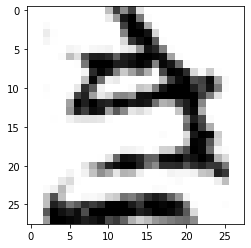

LABEL: 1
INPUT:


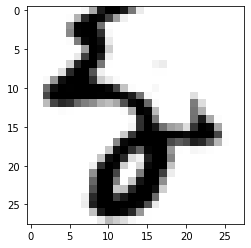

LABEL: 4
INPUT:


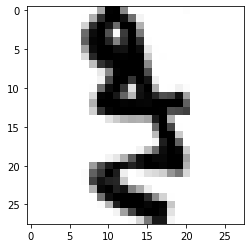

LABEL: 1


In [7]:
#let's try the plotting function
print(X_train.shape)
print(y_train)
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,1000)


### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [8]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
import pandas as pd

#1. Compare one hidden layer with different size
#parameters = {'hidden_layer_sizes': [(1,),(10,), (20,), (40,), (50,)]}

#2. Compare networks with different depth
#parameters = {'hidden_layer_sizes': [(10,),(10,10), (20,20), (20,30), (20,20,20)]}

#3. Compare different number of layers with different sizes too
parameters = {'hidden_layer_sizes': [(10,),(40,), (50,), (50,50), (50,50,50)]}

mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)


gridsearchcv = GridSearchCV(mlp,parameters,cv=5)
gridsearchcv.fit(X_train, y_train)

#ADD YOUR CODE

print ('RESULTS FOR NN\n')

best_hidden_layer_size = gridsearchcv.best_params_['hidden_layer_sizes']
print("Best hidden layer:",best_hidden_layer_size)


best_score = gridsearchcv.best_score_
print("Score with best hidden layer size:",best_score)

print("All scores on the grid:")
results = gridsearchcv.cv_results_
dfresults = pd.DataFrame(results)
dfresults

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RESULTS FOR NN

Best hidden layer: (50,)
Score with best hidden layer size: 0.76
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.370760,0.011925,0.000796,0.000398,"(10,)","{'hidden_layer_sizes': (10,)}",0.685484,0.745902,0.689076,0.739496,0.741379,0.720000,0.027130,5
1,0.465043,0.028372,0.000998,0.000002,"(40,)","{'hidden_layer_sizes': (40,)}",0.701613,0.770492,0.731092,0.806723,0.758621,0.753333,0.035799,3
2,0.556637,0.044618,0.000997,0.000631,"(50,)","{'hidden_layer_sizes': (50,)}",0.725806,0.770492,0.747899,0.806723,0.750000,0.760000,0.027301,1
3,0.579386,0.078761,0.001594,0.000488,"(50, 50)","{'hidden_layer_sizes': (50, 50)}",0.709677,0.770492,0.731092,0.815126,0.758621,0.756667,0.036103,2
4,0.448941,0.020931,0.001395,0.000797,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",0.733871,0.770492,0.731092,0.773109,0.750000,0.751667,0.017697,4


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [9]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!

#parameters = {'batch_size': [1, 32, 100, 200, 300, 400, 450, 480]}
parameters = {'batch_size': [1,10,50,100,200,300,480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits=5)

mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size, max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

gridsearchcv2 = GridSearchCV(mlp,parameters,cv=kf)
gridsearchcv2.fit(X_train, y_train)

# recall to use cv=kf to use the k-fold subdivision seen in the lectures

print ('RESULTS FOR NN\n')

best_parameter = gridsearchcv2.best_params_
best_batch_size = best_parameter['batch_size']
print("Best batch size:",best_batch_size)

best_score = gridsearchcv2.best_score_
print("Score with best batch size:",best_score)

print("All scores on the grid:")
results = gridsearchcv2.cv_results_
dfresults = pd.DataFrame(results)
dfresults

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged 

RESULTS FOR NN

Best batch size: 50
Score with best batch size: 0.7583333333333333
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.966183,5.526985,0.001196,3.984468e-04,1,{'batch_size': 1},0.133333,0.100000,0.100000,0.108333,0.083333,0.105000,0.016330,7
1,1.431180,0.364693,0.000798,3.992103e-04,10,{'batch_size': 10},0.591667,0.733333,0.641667,0.650000,0.650000,0.653333,0.045522,6
2,0.472674,0.037319,0.000996,3.295355e-06,50,{'batch_size': 50},0.750000,0.800000,0.716667,0.783333,0.741667,0.758333,0.029814,1
3,0.499797,0.037079,0.000997,6.310529e-04,100,{'batch_size': 100},0.741667,0.800000,0.733333,0.766667,0.733333,0.755000,0.025604,3
4,0.673815,0.105419,0.001197,3.991395e-04,200,{'batch_size': 200},0.750000,0.816667,0.700000,0.775000,0.733333,0.755000,0.039299,3
5,0.580371,0.043699,0.000997,7.478899e-07,300,{'batch_size': 300},0.750000,0.808333,0.725000,0.775000,0.733333,0.758333,0.030277,1
6,0.624047,0.048348,0.000998,1.386932e-06,480,{'batch_size': 480},0.750000,0.808333,0.716667,0.766667,0.733333,0.755000,0.031447,3


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?

## [ANSWER TO QUESTION 1]

If we have the same number of hidden layers (#comparison1), the model will be more accurate if the size of this hidden layer is bigger. Comparing a hidden layer of size 1, 10, 20, 40, 50 the best model is the one with 50 neurons although among the results obtained with 20, 40 and 50 there is no a huge difference.

For this classification problem, analysing results in #comparison2, I see that having a bigger number of layers doesn't guarantee to create a  more accurate model. But when we have more neurons in the hidden layers the models get better results.

In fact, in #comparison3 the best results are obtained just with one hidden layer with 50 neurons.

Before discussing the results with the different batch sizes, I'm going to define this parameter and epoch.

The batch size is the number of samples that are passed to the network at once and the epoch is the pass of all the training data to the network. So the larger the batch size, the faster the model will complete the epoch. Generally, if we use a batch_size too large, it will lead to poor generalization.

The best results are obtained with batch_size = 50. When the batch_size = 1 or 480, the algorithm couldn't converge.



### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

[7960, 31810, 39760, 42310, 44860]
Training MLP of size (10,) ...
Training accuracy: 1.0
Test accuracy: 0.721
Done, training time: 0.67 sec

Training MLP of size (40,) ...
Training accuracy: 1.0
Test accuracy: 0.75575
Done, training time: 0.81 sec

Training MLP of size (50,) ...
Training accuracy: 1.0
Test accuracy: 0.7535
Done, training time: 0.72 sec

Training MLP of size (50, 50) ...
Training accuracy: 1.0
Test accuracy: 0.7685
Done, training time: 0.64 sec

Training MLP of size (50, 50, 50) ...
Training accuracy: 1.0
Test accuracy: 0.75925
Done, training time: 0.63 sec



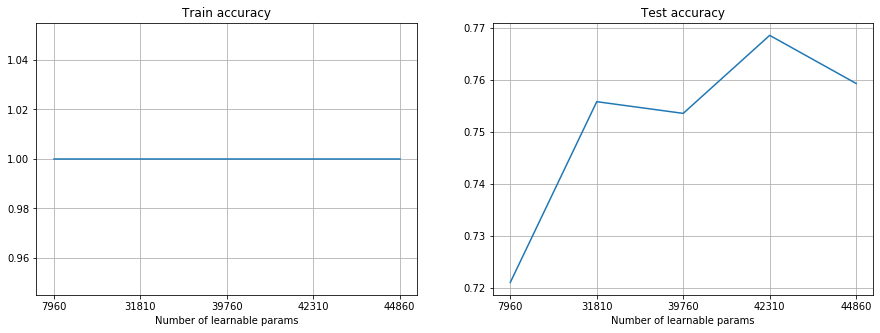

In [10]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(10,),(40,), (50,), (50,50), (50,50,50)]
hl_labels = [param_count(t) for t in hl_sizes]
print(hl_labels)

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(hidden_layer_sizes=hl_size, max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)
    
    mlp.fit(X_train,y_train)
    
    print("Training accuracy:",mlp.score(X_train,y_train))
    print("Test accuracy:",mlp.score(X_test,y_test))
   
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

## [ANSWER TO QUESTION 2]

The train accuracy of these models is always 100% regardless the number of learnable parameters. However, generally when the number of learnable parameters is smaller  the test accuracy is lower. 

When the number of learnable parameters is equal to 7960 we are seeing an overfitting issue.



### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged 

RESULTS FOR NN

Best learning rate: 0.02
Score with best parameters: 0.76


C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


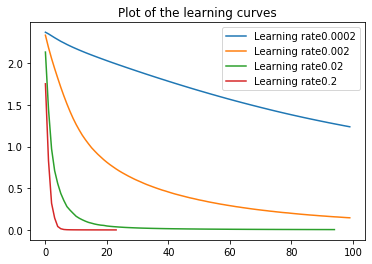

In [11]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.2]
parameters = {'learning_rate_init': lr_list}
scores = {}
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size,batch_size=best_batch_size, max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID)

gridsearchcv3 = GridSearchCV(mlp,parameters,cv=kf)
gridsearchcv3.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

best_learning_rate = gridsearchcv3.best_params_['learning_rate_init']

print("Best learning rate:", best_learning_rate)

print("Score with best parameters:",gridsearchcv3.best_score_)

plt.figure()
plt.title('Plot of the learning curves')
for lri in lr_list:
    mlpwithlri = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size,batch_size=best_batch_size, max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,learning_rate_init=lri)
    
    mlpwithlri.fit(X_train,y_train)
    loss_curve = mlpwithlri.loss_curve_
    
    plt.plot(loss_curve,label= "Learning rate"+str(lri))

plt.legend()
    
    
    
    



### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

## [ANSWER TO QUESTION 3]

The higher the learning rate, the less number of  iterations  it takes to reach low loss. So the speed of covergence is bigger, but at the same time, is more unstable as we can see with LR=0.2.

We observe that with LR=0.02 the lowest loss is obtained before reaching the maximum number of iterations(100). 

We observe that with LR=0.0002 the loss_curve decreases almost linearly and reaches the maximum number of iterations with a high loss in comparison with the others.



### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).


RESULTS FOR BEST NN

Best NN training error: 0.0
Best NN test error: 0.24875000000000003


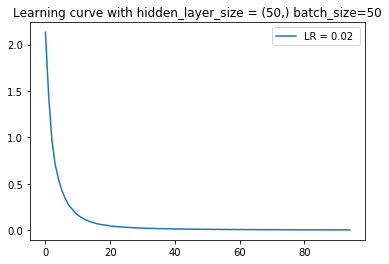

In [12]:
#get training and test error for the best NN model from CV

best_mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size,batch_size=best_batch_size, max_iter=500, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,learning_rate_init=best_learning_rate)
best_mlp.fit(X_train,y_train)


training_error = 1 - best_mlp.score(X_train,y_train)
test_error = 1 - best_mlp.score(X_test,y_test)


print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error:", training_error)
print ("Best NN test error:", test_error)


loss_curve = best_mlp.loss_curve_
plt.title("Learning curve with hidden_layer_size = (50,) batch_size=50")
plt.plot(loss_curve,label="LR = 0.02 ")
plt.legend()


## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [13]:
X = X[permutation]
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [405 355 408 402 412 386 412 391 420 409]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [14]:

larger_best_mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size,batch_size=best_batch_size, max_iter=50,verbose=True, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,learning_rate_init=best_learning_rate)

larger_best_mlp.fit(X_train,y_train)

training_error = 1 - larger_best_mlp.score(X_train,y_train)
test_error = 1 - larger_best_mlp.score(X_test,y_test)


print ('\nRESULTS FOR NN\n')


print ("NN training error: ", training_error)
print ("NN test error:" , test_error)


Iteration 1, loss = 1.20622945
Iteration 2, loss = 0.62131833
Iteration 3, loss = 0.47885704
Iteration 4, loss = 0.38928019
Iteration 5, loss = 0.32297877
Iteration 6, loss = 0.27151080
Iteration 7, loss = 0.22614336
Iteration 8, loss = 0.18617379
Iteration 9, loss = 0.16064204
Iteration 10, loss = 0.13717285
Iteration 11, loss = 0.11454700
Iteration 12, loss = 0.09578999
Iteration 13, loss = 0.07911719
Iteration 14, loss = 0.06804800
Iteration 15, loss = 0.05949739
Iteration 16, loss = 0.05045838
Iteration 17, loss = 0.04372052
Iteration 18, loss = 0.03877010
Iteration 19, loss = 0.03317661
Iteration 20, loss = 0.02998432
Iteration 21, loss = 0.02669938
Iteration 22, loss = 0.02371244
Iteration 23, loss = 0.02134797
Iteration 24, loss = 0.02004562
Iteration 25, loss = 0.01796991
Iteration 26, loss = 0.01656208
Iteration 27, loss = 0.01541069
Iteration 28, loss = 0.01422303
Iteration 29, loss = 0.01333340
Iteration 30, loss = 0.01253898
Iteration 31, loss = 0.01184471
Iteration 32, los

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



RESULTS FOR NN

NN training error:  0.0
NN test error: 0.1347857142857143


## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

#### [ANSWER TO QUESTION 4]

The training error is the same with 600  and 4000 training samples. However, the test error is getting smaller when the number of training samples increases.
This makes sense, because the model is trained with more data and can be more accurate and generalized.

### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

INPUT:


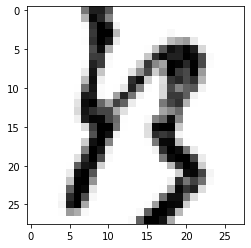

LABEL: 1
Real Y: 1
Y predicted wrongly by NN 600 training points: 8
Y predicted correctly by NN 4000 training points: 1


In [15]:
NN_prediction = best_mlp.predict(X_test)
large_NN_prediction = larger_best_mlp.predict(X_test)
m_test = X_test.shape[0]

for i in range(m_test):
    if (NN_prediction[i]!=y_test[i] and large_NN_prediction[i]==y_test[i]):
        plot_input(X_test,y_test,i)
        print("Real Y:",y_test[i])
        print("Y predicted wrongly by NN 600 training points:",NN_prediction[i])
        print("Y predicted correctly by NN 4000 training points:",large_NN_prediction[i])
        break
        
    


        

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


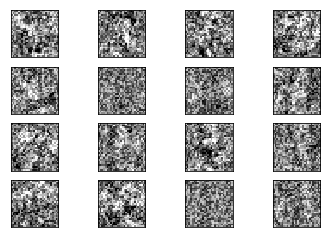

Weights with 4000 data points:


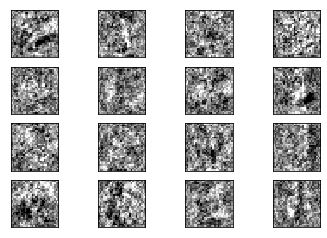

In [16]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = best_mlp.coefs_[0].min(), best_mlp.coefs_[0].max()
for coef, ax in zip(best_mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = larger_best_mlp.coefs_[0].min(), larger_best_mlp.coefs_[0].max()
for coef, ax in zip(larger_best_mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 5

Describe what do you observe by looking at the weights.

##### [ANSWER TO QUESTION 5]

I would say that the weights for the MLPClassifier with 4000 training data points has more details.

If we compare the weight which is in the last row, third column,  the weight with 600 data points is almost grey while the weight with 4000 data points has more shades of black and white.

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [17]:
m_training = 5000

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# use best parameters found in the SVM notebook, create SVM and perform fitting

best_SVM = SVC(C=10,kernel='rbf',gamma=0.01)
best_SVM.fit(X_train,y_train)

SVM_training_error = 1 - best_SVM.score(X_train,y_train)
SVM_test_error = 1 - best_SVM.score(X_test,y_test)

print ('RESULTS FOR SVM')

print("Training score SVM:",SVM_training_error)
print("Test score SVM:",SVM_test_error)


RESULTS FOR SVM
Training score SVM: 0.0
Test score SVM: 0.08420000000000005


In [21]:
#MLP with 5000 training data points
larger_best_mlp2 = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size,batch_size=best_batch_size, max_iter=100,verbose=True, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,learning_rate_init=best_learning_rate)

larger_best_mlp2.fit(X_train,y_train)

NN_training_error = 1 - larger_best_mlp2.score(X_train,y_train)
NN_test_error = 1 - larger_best_mlp2.score(X_test,y_test)

print ('RESULTS FOR NN')

print("Training score NN:",NN_training_error)
print("Test score NN:",NN_test_error)

Iteration 1, loss = 1.11463521
Iteration 2, loss = 0.57259483
Iteration 3, loss = 0.44954852
Iteration 4, loss = 0.36110279
Iteration 5, loss = 0.29956414
Iteration 6, loss = 0.24595259
Iteration 7, loss = 0.21179782
Iteration 8, loss = 0.17919910
Iteration 9, loss = 0.14959947
Iteration 10, loss = 0.12649753
Iteration 11, loss = 0.10414956
Iteration 12, loss = 0.08853944
Iteration 13, loss = 0.07360701
Iteration 14, loss = 0.06355278
Iteration 15, loss = 0.05388599
Iteration 16, loss = 0.04792401
Iteration 17, loss = 0.04147838
Iteration 18, loss = 0.03621274
Iteration 19, loss = 0.03202638
Iteration 20, loss = 0.02843374
Iteration 21, loss = 0.02491235
Iteration 22, loss = 0.02284835
Iteration 23, loss = 0.02092434
Iteration 24, loss = 0.01885992
Iteration 25, loss = 0.01692621
Iteration 26, loss = 0.01565348
Iteration 27, loss = 0.01445227
Iteration 28, loss = 0.01352706
Iteration 29, loss = 0.01245307
Iteration 30, loss = 0.01167076
Iteration 31, loss = 0.01115398
Iteration 32, los

In [18]:
from sklearn import linear_model

regL2 = linear_model.LogisticRegression(C=1.0)
regL2.fit(X_train,y_train)


#ADD YOUR CODE

print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')

training_error = 1 - regL2.score(X_train,y_train) 
test_error = 1 -  regL2.score(X_test,y_test)

print ("Training error (reg):", training_error)
print ("Test error (reg):", test_error)

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
Training error (reg): 0.06279999999999997
Test error (reg): 0.2338


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

###### [ANSWER TO QUESTION 6]

The best results to this classification problem are obtained with SVM model because after training it we obtained the smallest test error (0.08) which is very accurate. 

After SVM, the best option will be the Neural Network because test error (0.123) is quite smaller than the one obtained when we use Logistic Regression Model (0.23).

Usually Logistic Regression is used to solve problems of binary classification. The classification in this problem is among 10 labels, so this could be one of the reasons why this method is the least accurate for solving this problem. 